#  Import deep learning libraries

In [1]:
from arcgis.gis import GIS

import torch
from fastai.conv_learner import *
from fastai.dataset import *

# Use training data

#### Load training data

In [2]:
from pathlib import Path
import json

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

import pickle

In [4]:
# defining the PATH variable which will be used to save and load files
PATH = Path('/home/splash/buildings/data/')

# tilemapping is a dictionary which contains mapping from image to bounding boxes
tilemapping = pickle.load(open(PATH/'tilemapping.pkl', 'rb'))
len(tilemapping)

377

In [5]:
# This cells defines some utility functions for plotting

def get_color(text):
    if text=='bg':
        c = 'gray'
    elif text=='building ':
        c = 'white'
    else:
        c = 'yellow'
    return c

def draw_outline(obj, width):
    obj.set_path_effects([patheffects.Stroke(linewidth=width, foreground='black'), patheffects.Normal()])

def draw_bbox(ax, bbox, text=None, i=None, pr=None):    
    c = get_color(text)
    patch = ax.add_patch(patches.Rectangle(xy=(bbox[1], bbox[0]), width=bbox[3]-bbox[1],
                                           height=bbox[2]-bbox[0], 
                                           fill=False, edgecolor=c, lw=2))
    draw_outline(patch, 4)
    if i is not None:
        text = text
    if pr is not None:
        text = text + f' {pr:.2f}'
    if text is not None:
        t = ax.text(bbox[1], bbox[0], s=text, color='white', fontsize=12,
                    verticalalignment='bottom', weight='bold') #,bbox=dict(facecolor=c, pad=2))
        draw_outline(t, 1)

def draw_img_bboxes(ax, img, bboxes, classes=None, prs=None, thresh=0.3):
    
    if prs is None:  
        prs  = [None]*len(bboxes)
    if classes is None: 
        classes = [1]*len(bboxes)
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(img);
    for i, (bbox, c, pr) in enumerate(zip(bboxes, classes, prs)):
        if((bbox[3] - bbox[1] > 0) and (pr is None or pr > thresh)):
            try: cat = categories[c]
            except: cat = 'bg'
            draw_bbox(ax, bbox, cat, i, pr)
            
def draw_image(filename):
    fig, ax = plt.subplots(figsize=(4,4))
    img = open_image(PATH / 'images' / filename)
    
    bboxes=[]
    for center in tilemapping[filename]:
        bboxes.append(get_bbox(center))
        
    draw_img_bboxes(ax, img, bboxes)

In [25]:
# Define categories which the image contains
categories = {0: 'ground', 1: 'building'}

sz = 224
objsize = 30


# In dataframe the bounding boxes coordinates are passed as string which are joined using spaces
# The following function convert bounding boxes to string
def get_bboxes_str(filename):
    bboxes = ''
    for center in tilemapping[filename]:
        bboxes = bboxes + ' '.join(str(c) for c in (get_bbox(center)))
        bboxes = bboxes + ' '
    return bboxes

# a function to convert bounding center location coordinates to boxxes
def get_bbox(center):
    xpix, ypix = int(sz*center[0]), int(sz*(1.0-center[1]))
        
    xmin, xmax = xpix - objsize//2, xpix + objsize//2 + 2
    ymin, ymax = ypix - objsize//2, ypix + objsize//2 + 2
    xmin = xmin # if xmin > 0 else 0
    ymin = ymin # if ymin > 0 else 0
    xmax = xmax # if xmax < sz else sz
    ymax = ymax # if ymax < sz else sz
    return [ymin, xmin, ymax, xmax]

bboxes_dict = {name: get_bboxes_str(name).strip()
                   for name, centers in tilemapping.items()}

# creating a pandas dataframe in the specific format
bboxes_df = pd.DataFrame.from_dict(bboxes_dict, orient='index').reset_index()
bboxes_df.columns = ['fn', 'bbox']

MULTIBOX_CSV = PATH/'bboxes.csv' # CSV file to use
bboxes_df.sort_values(by='fn', inplace=True)
bboxes_df.to_csv(MULTIBOX_CSV, index=False)
bboxes_df.head()

,fn,bbox
216,000000020.jpg,38 207 70 239
249,000000021.jpg,38 95 70 127
81,000000022.jpg,150 207 182 239
343,000000023.jpg,150 95 182 127
33,000000026.jpg,23 79 55 111


In [26]:
model = resnet34                 # Base model to be used for transfer learning
sz = 224                         # size of images to be used
bs = 64                          # batch size
JPEGS = 'images'                 # folder name which contains images

In [27]:
# Reading the CSV from the disk
bboxes_df = pd.read_csv(MULTIBOX_CSV)

# Calculating the number of objects column for every row in the Dataframe
bboxes_df['n'] = bboxes_df['bbox'].apply(lambda x: len(x.split(' ')) // 4)

object_classes = np.array([np.ones(row['n']).astype(int) for index, row in bboxes_df.iterrows()])

# The following line splits the training and validation sets based on their index
val_idxs = get_cv_idxs(len(object_classes))
((val_classes, train_classes),) = split_by_idx(val_idxs, object_classes)

len(val_classes), len(train_classes)

(75, 302)

In [28]:
# Defining the augmentation and getting the model data object which will be used to create the model

aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.5, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]

tfms = tfms_from_model(model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)

model_data = ImageClassifierData.from_csv(PATH, JPEGS, MULTIBOX_CSV, tfms=tfms, continuous=True)

In [29]:
# Creating a python class to merge classes of the bounding boxes into the model_data

class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2
        self.sz = ds.sz
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y1 = self.ds[i]
        y2 = self.y2[i]
        return (x, (y1, y2)) # y1 is bboxes y2 is classes

In [30]:
# merging the classes into the model_data object with the class of the label

train_dataset = ConcatLblDataset(model_data.trn_ds, train_classes)
val_dataset   = ConcatLblDataset(model_data.val_ds, val_classes)

model_data.trn_dl.dataset = train_dataset
model_data.val_dl.dataset = val_dataset

In [31]:
x, y = to_np(next(iter(model_data.val_dl)))
x    = model_data.val_ds.ds.denorm(x)

def show_training_data():
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for i,ax in enumerate(axes.flat):
        draw_img_bboxes(ax, x[i], y[0][i].reshape(-1, 4), y[1][i])
    plt.tight_layout()

#### Visualize image chips with bounding boxes

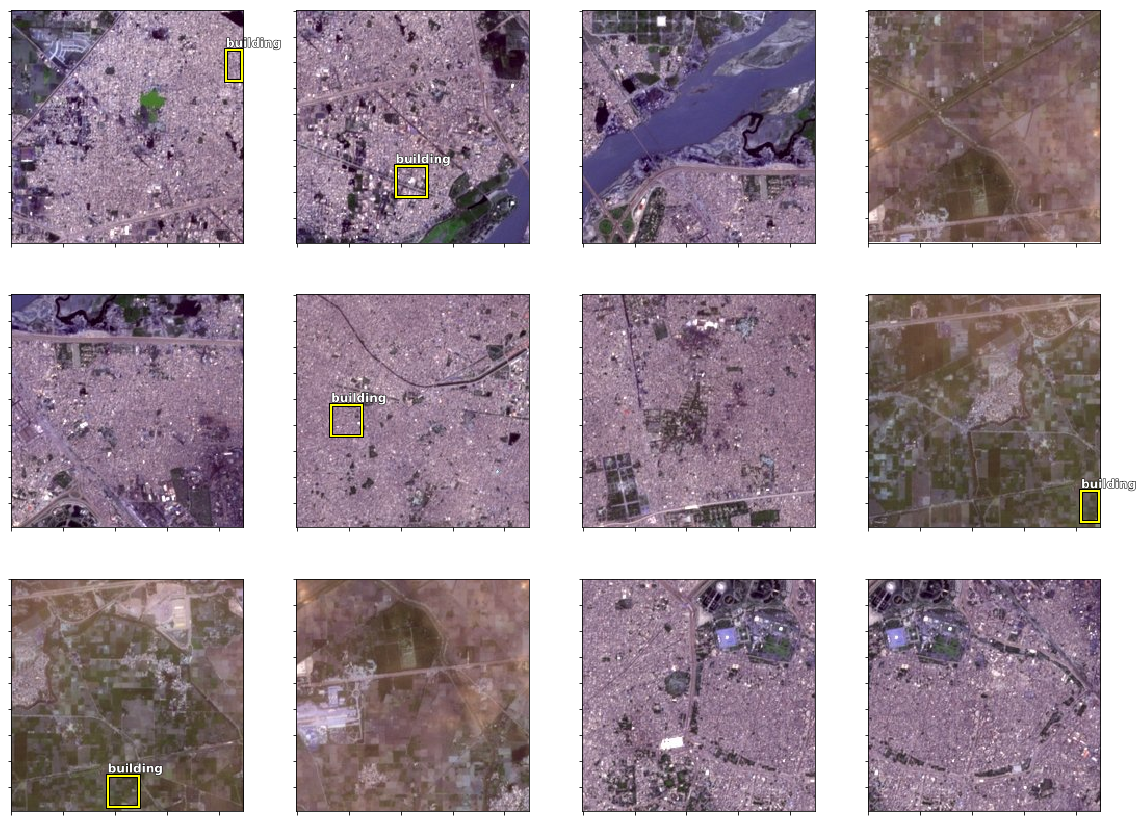

In [32]:
show_training_data()

# Train AI model

### Define Single Shot Detector (SSD) model architecture

In [33]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x, k):
    bs, nf, gx, gy = x.size()                # batch size, num filters, width, height
    x = x.permute(0, 3, 2, 1).contiguous()   # batch_size, 
    return x.view(bs, -1, nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1) # nclasses
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1) # bboxes
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]


class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c, o2c, o3c], dim=1),
                torch.cat([o1l, o2l, o3l], dim=1)]
    


In [34]:
# converts height width to corners
def hw2corners(ctr, hw): 
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

anc_grids = [4,2,1]
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]

anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

id2cat = list(categories.values())
cat2id = {v:k for k,v in enumerate(id2cat)}

n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

n_clas, n_act

(3, 63)

In [35]:
f_model = model # defining the base model for transfer learning
md = model_data # definig model data

drop=0.4

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [36]:
# defining the loss functions

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    try:
        inter = intersect(box_a, box_b)
        union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
        return inter / union
    except:
        return 0.

def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    try:
        xx = ((bbox[:,2]-bbox[:,0])>0).nonzero()
        #print(xx)
        bb_keep = xx[:,0]
    except:
        # print('No bboxes')
        return None, None
    
    #xx = ((bbox[:,2]-bbox[:,0])>0).nonzero()
    #bb_keep = xx[:,0]
    
    return bbox[bb_keep], clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:] # [-1, 1]/2 + 1 = [0.5, 1.5] * anchor ht, w
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c, b_bb, bbox, clas, print_it=False):
    bbox, clas = get_y(bbox, clas)             # bbox, class from target
    if bbox is None:
        return 0.0, 0.0
    a_ic = actn_to_bb(b_bb, anchors)           # predicted bbox
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)  # binary cross entropy
    return loc_loss, clas_loss

def ssd_loss(pred, targ, print_it=False):
    lcs, lls = 0.,0. # class loss, location loss
    for b_c, b_bb, bbox, clas in zip(*pred, *targ): 
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [37]:
anchors = anchors.cuda();
grid_sizes = grid_sizes.cuda(); 
anchor_cnr = anchor_cnr.cuda()

In [38]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

In [39]:
def draw_torch_img(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return draw_img_bboxes(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [40]:
def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)

    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): 
        gt_idx[o] = i
    return gt_overlap, gt_idx

### Train model using labeled training data


epoch      trn_loss   val_loss                         
    0      283.282246 221912.97026


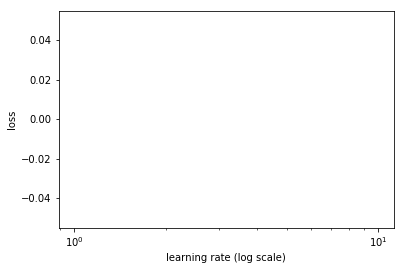

In [41]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

In [42]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))


epoch      trn_loss   val_loss                         
    0      276.726725 195.999673
    1      242.014482 198.790667                       
    2      218.470449 185.20374                        
    3      204.058929 178.833417                       


[array([178.83342])]

In [43]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))


epoch      trn_loss   val_loss                         
    0      168.46033  188.408294
    1      166.385976 186.822119                       
    2      161.305258 187.101012                       
    3      156.768049 179.451367                       


[array([179.45137])]

In [44]:
# Freeze all layers except last two(run it twice)
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))


epoch      trn_loss   val_loss                         
    0      158.124074 188.65832 
    1      150.995614 183.136374                       
    2      144.778154 181.696681                       
    3      139.916177 177.191099                       


[array([177.1911])]

In [45]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        draw_torch_img(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

#changing loss function to focal loss    
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))


epoch      trn_loss   val_loss                          
    0      26.539672  2901266.249167


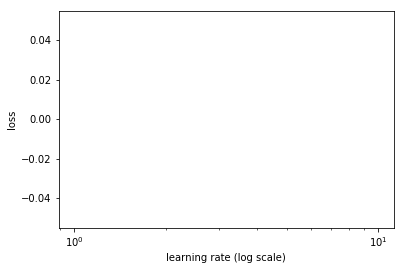

In [46]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=1)

In [47]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(20,10))


epoch      trn_loss   val_loss                          
    0      25.039656  38.173082 
    1      23.97511   36.912957                         
    2      23.279798  36.330961                         
    3      22.764039  36.055949                         
    4      22.144403  36.06895                          


[array([36.06895])]

In [48]:
learn.freeze_to(-2)
learn.fit(lrs/50, 1, cycle_len=4, use_clr=(20,10))


epoch      trn_loss   val_loss                          
    0      19.231722  36.169739 
    1      19.6574    36.151946                         
    2      19.419816  36.110929                         
    3      19.27534   36.128688                         


[array([36.12869])]

In [49]:
learn.save('8')

In [50]:
# unfreeze all layers and fine tune the complete model
learn.unfreeze()
learn.fit(lrs/250, 1, cycle_len=4, use_clr=(20,10))


epoch      trn_loss   val_loss                          
    0      22.52678   36.295496 
    1      22.804621  36.02069                          
    2      22.573803  35.900291                         
    3      22.785913  36.14531                          


[array([36.14531])]

In [51]:
learn.save('9')

# Evaluate results

### Detect swimming buildings in validation set

In [52]:
learn.load('9')

In [53]:
# the non maximal suppression function
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0:
        return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [54]:
# take out a batch
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

In [55]:
# non maximal suppression with comparisons
def show_results(idx, thresh=0.25, overlap=0.1):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > thresh
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, overlap, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    if cc == []:
        cc = [[0]]
    if out1 == []:
        out1 = [torch.Tensor()]
    if out2 == []:
        out2 = [torch.Tensor()]
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 45))
    
    torch_gt(ax2, ima, out2, cc, out1, 0.)
    title1_str = '# of predicted objects: '+ str(len([x for x in out1 if x > 0]))
    ax2.text(0,-10,title1_str)
    
    if bbox is None:
        bbox = torch.Tensor([0,0,0, 0])
    if clas is None:
        clas = torch.Tensor(0)
    torch_gt(ax3, ima, bbox, clas, None, 0.)
    title2_str = '# of ground truth objects: '+ str(len(clas))
    ax3.text(0,-10,title2_str)
    
    show_img(ima, ax=ax1)
    title3_str = md.val_ds.ds.fnames[i]
    ax1.text(0,-10,title3_str)
    ax1.grid(False)    
    
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f''
#             print(c)
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])    
            
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
#     ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]   

### Compare image, predictions and ground truth

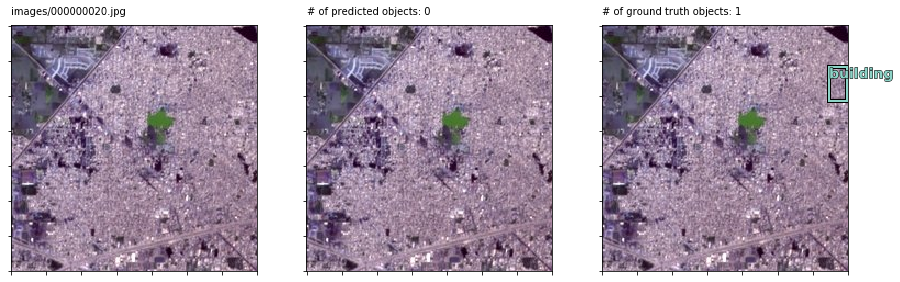

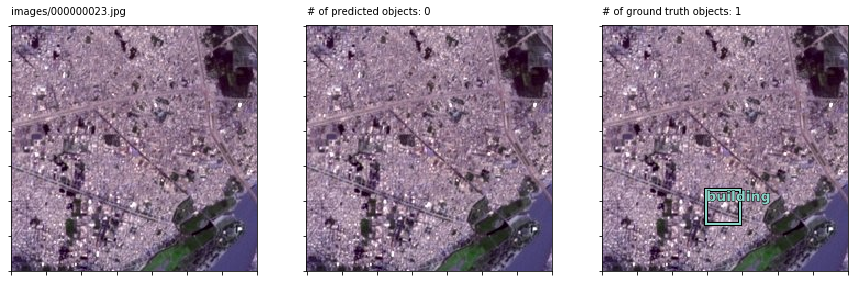

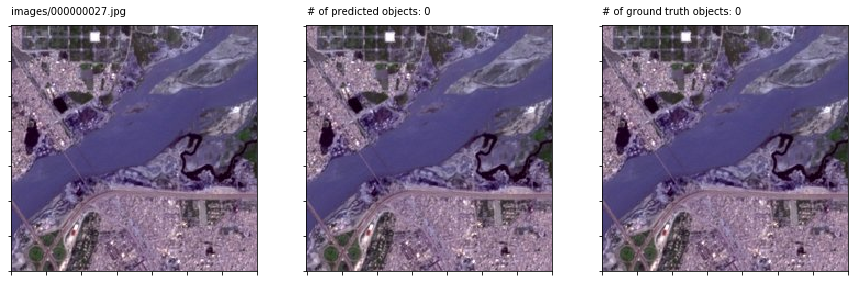

In [56]:
for i in range(3):
    show_results(i, overlap=0.05)

# Test model

### Define area of interest

In [57]:
from arcgis.gis import GIS
from arcgis.features import SpatialDataFrame
from arcgis.raster import ImageryLayer
from arcgis.raster.functions import apply
from PIL import Image
import os

gis = GIS('https://deldev.maps.arcgis.com', 'demo_deldev', os.environ.get('DEMOSPWD'))

KeyboardInterrupt: 

In [ ]:
naip = gis.content.search('id:e4da3b6720f545aeaaf3fe8141da1e21', 'Imagery Layer', outside_org=True)[0];
naip

In [ ]:
naiplayer = naip.layers[0]
naipfalse = apply(naiplayer, 'FalseColorComposite')

In [ ]:
PATH = Path('data/building/falsecolorcomposite_noaspect_neg')
filename = 'redlands.jpg'     

xmid = -13041888.801873
ymid = 4033154.412982

xmin, ymin = xmid - 90*4, ymid - 90*4
xmax, ymax = xmid + 90*4, ymid + 90*4

ext = {'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax, 'spatialReference':3857}
imgpath = naipfalse.export_image(ext, image_sr={'wkid': 4326},
                      bbox_sr=3857, size=[224*8, 224*8], f='image', export_format='jpg', 
                      save_folder=PATH,
                      save_file=filename)

In [ ]:
def get_img(filename):
    return np.array(Image.open(filename))

def get_tile_images(image, width=224, height=224):
    _nrows, _ncols, depth = image.shape
    _size = image.size
    _strides = image.strides

    nrows, _m = divmod(_nrows, height)
    ncols, _n = divmod(_ncols, width)
    if _m != 0 or _n != 0:
        return None

    return np.lib.stride_tricks.as_strided(
        np.ravel(image),
        shape=(nrows, ncols, height, width, depth),
        strides=(height * _strides[0], width * _strides[1], *_strides),
        writeable=False)

def predict_(model,images):
    images = V(images)
    if not len(images.size()) > 3:
        images.data = images.data.view(1,*images.size())
    bbox,clas = model(images)
    return bbox,clas

imagenet_stats = A([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

mean = 255* np.array(imagenet_stats[0], dtype=np.float32)
std  = 255* np.array(imagenet_stats[1], dtype=np.float32)

norm = lambda x: (x-mean)/ std
denorm = lambda x: x * std + mean

learn.model.eval();

In [ ]:
img = get_img(PATH/filename)
_nrows = int(img.shape[0] / 224)
_ncols = int(img.shape[1] / 224)
img = get_tile_images(img)
img = img.reshape(64,224,224,3)
img_normed = norm(img)

In [ ]:
clas, bbox = predict_(learn.model,img_normed.transpose(0,3,1,2))

In [ ]:
def visualize_results(images,b_clas,b_bb,idx,anchors,ax1):
    ax1.set_axis_off()
    if not len(images.shape) > 3:
        images = images[np.newaxis,:]
    ima = denorm(images[idx]).astype(int)
    
#     bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1, out2, cc = [], [], []
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.1
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.1, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
#         print(cc)
#     print(cc)
    if cc == []:
        cc = [[0]]
    cc = T(np.concatenate(cc))
#     print(out1)
    if out1 == []:
        out1 = [torch.Tensor()]
    out1 = torch.cat(out1)
    if out2 == []:
        out2 = [torch.Tensor()]
    out2 = torch.cat(out2)
    
    torch_gt(ax1, ima, out2, cc, out1, 0.)


### Detect buildings in area of interest

In [ ]:
fig, ax = plt.subplots(nrows=_nrows, ncols=_ncols, figsize=(24, 24))
plt.subplots_adjust(hspace=0.01, wspace=0.01)

for idx in range(bbox.size()[0]): 
    
    visualize_results(img_normed, clas, bbox, idx, anchors, ax[idx//8, idx%8])